# Attributable Protein Language Model (ESMattribution) with Ridge Regression
This notebook demonstrates training and getting per residue attribution from and ESM2 based model.  Here we use the ESM2 model without modification but use ridge regression to transform those representations into a per-residue prediction. The demonstration uses fraction alpha helix predictions from the AlphaFold database (https://alphafold.ebi.ac.uk/) as calculated by the stride program (https://webclu.bio.wzw.tum.de/stride/). If the sequence id is a uniprot id, the code can download the alphafold prediction and display the per residue fration alpha attribution as a false color. This code can be run google colab at this link: http://colab.research.google.com/github/jayunruh/esm2_attributes/blob/main/ridge_attribute_fraction_alpha.ipynb

In [1]:
#if you are using this from google colab, you need the utility modules
#(everything else should already be installed)
!pip install py3dmol
import os
if(not os.path.exists('model_utils.py')):
    print('downloading model libraries')
    !wget https://raw.githubusercontent.com/jayunruh/ESMattribution/refs/heads/main/model_utils.py
if(not os.path.exists('jpdbtools.py')):
    !wget https://raw.githubusercontent.com/jayunruh/Jay_pdbtools/refs/heads/main/jpdbtools.py
    !wget https://raw.githubusercontent.com/jayunruh/Jay_pdbtools/refs/heads/main/jpdbtools2.py
else:
    print('libraries already downloaded')
#download the training data (upload by hand for customization)
if(not os.path.exists('yeast_af_ssstats2.csv')):
    print('downloading training data')
    !wget https://raw.githubusercontent.com/jayunruh/ESMattribution/refs/heads/main/yeast_af_ssstats2.csv

libraries already downloaded


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sys
import jpdbtools as jutils
#model_utils contains the model definition
import model_utils
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import scipy.stats as ss
from sklearn.linear_model import Ridge
import requests

In [2]:
# Set the device (cpu or gpu)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device=model_utils.device
print(f"Using device: {device}")

Using device: cpu


In [3]:
#read in our data set
df=pd.read_csv('yeast_af_ssstats2.csv')
print('data set average fraction helix',df['f_alpha'].mean())

data set average fraction helix 0.40834940571997513


In [4]:
#Load the ESM model
esm_model,esmlayer,batch_converter,alphabet=model_utils.loadESMModel(nlayers=33,device=device)

Loading ESM-2 model...


Using cache found in /Users/jru/.cache/torch/hub/facebookresearch_esm_main
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /Users/jru/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /Users/jru/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM-2 model loaded.


In [5]:
# Next run the ESM2 model without training to get the per residue representations
reprs=model_utils.getESM2Representations(esm_model,batch_converter,df['sequence'],rep_layer=esmlayer)

  0%|          | 0/6039 [00:00<?, ?it/s]

In [7]:
#save the representation matrices
np.savez(f"representation_{esmlayer}_layer.npz",*reprs)

In [8]:
#now calculate the projections of those representations across the sequence
#the projection is the average representation for the protein
repprojs=np.array([reprs[i][0].mean(axis=0) for i in range(len(reprs))])

In [9]:
#save the projections
np.save(f"repr_projections_{esmlayer}_layer.npy",repprojs)

In [12]:
#load the previous projections if they are already calculated
repprojs=np.load("repr_projections_33_layer.npy")

In [13]:
#run the ridge regression across the projections
#higher alpha values constrain the weights to be lower on average
#the model should have the weighted contributions of each layer to the alpha fraction
regmodel=Ridge(alpha=0.5).fit(repprojs,df['f_alpha'])

In [14]:
#predict all of the protein labels
pred=regmodel.predict(repprojs)

In [15]:
#get accuracy statistics
df['ridge_prediction']=pred
accuracy=(1.0-np.abs(df['ridge_prediction']-df['f_alpha'])).mean()
print('Overall accuracy = ',accuracy)

Overall accuracy =  0.9626880004030269


In [16]:
df.to_csv('yeast_fractionalpha_ridgepredictions.csv')

In [17]:
#calculate the R^2 for our regression predictions
regresults=ss.linregress(df['f_alpha'],df['ridge_prediction'])
r2=regresults.rvalue**2
print('R^2 = ',r2)

R^2 =  0.9076337778694297


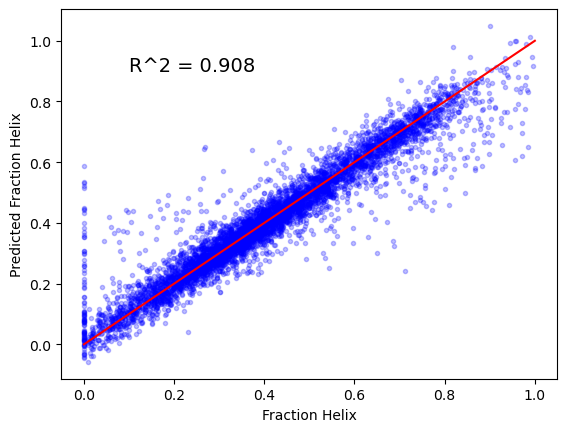

In [25]:
plt.plot(df['f_alpha'],df['ridge_prediction'],'b.',alpha=0.25)
plt.plot([0,1],[0,1],'r-')
plt.xlabel('Fraction Helix')
plt.ylabel('Predicted Fraction Helix')
plt.text(0.1,0.9,f"R^2 = {r2:.3f}",fontsize=14)
plt.show()

In [26]:
#now predict the sequence specific contributions from the representation matrices
#note that the npz file is a dictionary of arrays
reprfs=np.load('representation_33_layer.npz')

In [27]:
#for each matrix use the ridge model to predict the contribution of each residue
attrmat=np.full([len(df),2000],np.nan)
pos=0
for name in reprfs:
    #print(name,reprs[name].shape)
    attr=regmodel.predict(reprfs[name][0])
    attrlen=min(len(attr),2000)
    attrmat[pos,:attrlen]=attr[:attrlen]
    pos+=1

In [28]:
#save the attribution matrix
np.save('yeast_fractionalpha_data_ridge_attributions.npy',attrmat)

Text(0, 0.5, 'Test Sequence')

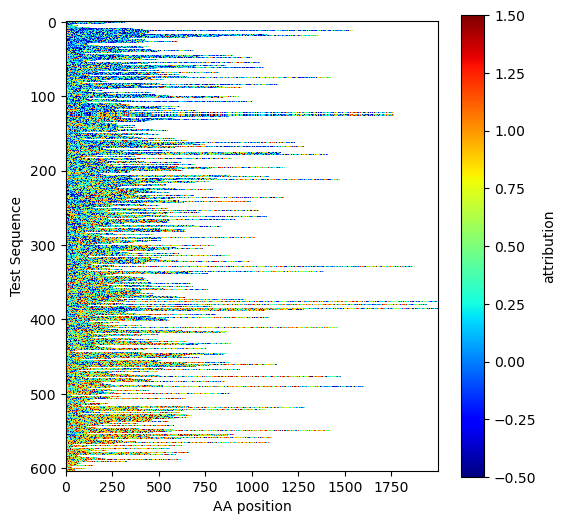

In [36]:
#show a heatmap of some of the attributions sorted by fraction alpha
dfsort=df.sort_values('f_alpha',ascending=True)
plt.figure(figsize=(6,6))
plt.imshow(attrmat[dfsort.index][::10],cmap='jet',vmin=-0.5,vmax=1.5,interpolation='None',aspect=4.0)
plt.colorbar(label='attribution')
plt.xlabel('AA position')
plt.ylabel('Test Sequence')

selected index 4131
selected id: P87284
label: 0.8545454545454545 prediction: 0.89325225


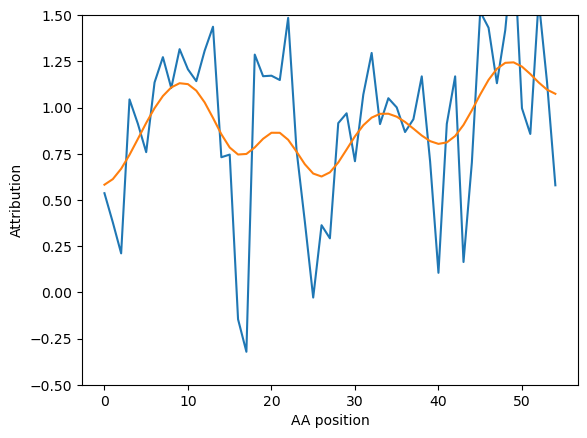

In [49]:
#show the attribution for a selected target
selidx=dfsort.index[-100]
print('selected index',selidx)
tid=df.loc[selidx,'upid']
print('selected id:',tid)
print('label:',df.loc[selidx,'f_alpha'],'prediction:',df.loc[selidx,'ridge_prediction'])
seq=df.loc[selidx,'sequence']
seqlen=min(len(seq),2000)
attr=attrmat[selidx,:seqlen]
smattr=ndi.gaussian_filter(attr,sigma=3)
plt.plot(attr)
plt.plot(smattr)
plt.ylim(-0.5,1.5)
plt.xlabel('AA position')
plt.ylabel('Attribution')
plt.show()

In [50]:
#finally load the alphafold structure
selid=tid
print('getting af2 prediction for id',selid)
url='https://alphafold.ebi.ac.uk/files/AF-'+selid+'-F1-model_v4.pdb'
pdbstr=requests.get(url).text

getting af2 prediction for id P87284


In [51]:
pdbdf=jutils.cleanpdbdf(jutils.jpt2.getpdbdffromstr(pdbstr))
pdbdf.head()

,type,atom,atype,resname,chain,residue,x,y,z,unk,temp,element
0,ATOM,1,N,MET,A,1,6.370,-9.100,15.528,1.0,56.09,N
1,ATOM,2,CA,MET,A,1,5.808,-8.499,14.303,1.0,56.09,C
2,ATOM,3,C,MET,A,1,4.879,-9.529,13.712,1.0,56.09,C
3,ATOM,4,CB,MET,A,1,6.896,-8.135,13.278,1.0,56.09,C
4,ATOM,5,O,MET,A,1,5.344,-10.628,13.432,1.0,56.09,O


In [52]:
#map the smoothed attribution to the residues
resmap={i+1:smattr[i] for i in range(len(smattr))}
pdbdf['temp']=pdbdf['residue'].map(resmap)
#write the mapped pdb if desired
_=jutils.writepdbdf(pdbdf,selid+'_ridge_mapped.pdb')

In [53]:
view=jutils.py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',width=600,height=600)
view.addModel(jutils.writepdbdf(pdbdf),'pdb')
#view.addModel(pdbstr,'pdb') #to view the raw AF data
view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':1}}})
#view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.